# Proyecto 1 Microestructuras y sistemas de Trading

## Paqueterias

In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

### Config Graficos

In [12]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(
    color=["skyblue", "steelblue", "navy", "royalblue", "mediumslateblue"]
)

# Distribucion Earlang

$$
f(x;k, \lambda) = \frac{\lambda^k x^{k-1} e^{-\lambda x}}{(k-1)!} \quad\quad para \quad x,\lambda \geq 0
$$

In [13]:
def PDF_erlang(k, lmbda, S):
    return (lmbda ** k * S ** (k - 1) * np.exp(-lmbda * S)) / math.factorial(k - 1)

Text(0, 0.5, 'Dendidad de probabilidad')

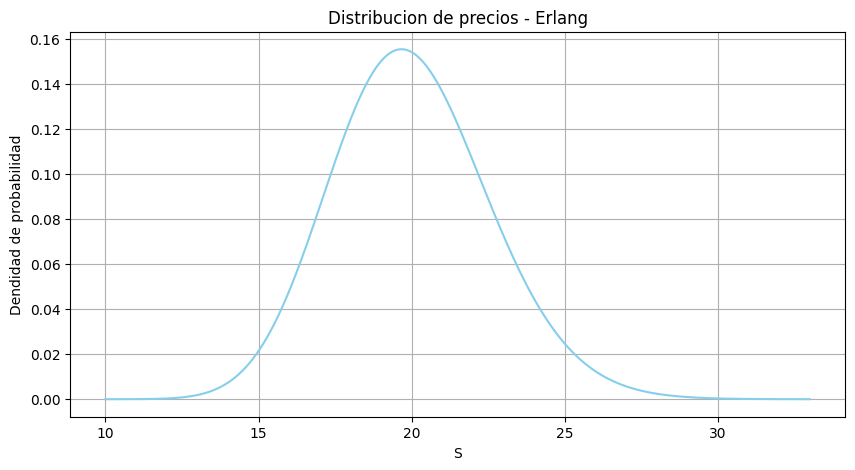

In [14]:
k = 60
lmbda = 3
S = np.linspace(10, 33, 1000)

erlang = PDF_erlang(k, lmbda, S)

plt.plot(S, erlang)
plt.title('Distribucion de precios - Erlang')
plt.xlabel('S')
plt.ylabel('Dendidad de probabilidad')

# Expected Revenues

- If all trades are liquidity trades
    - $\prod_{LB}=\prod_{LS}=0.5$

- If there is a 40% chance that an informed trade will be executed
    - Se mantiene → $\prod_{LB}=\prod_{LS}=0.5$

- Considering:

    - $\prod_{I} = 0.4$
    - $\prod_{LB}(S)= 0.5 - 0.08 S \quad where \quad \prod_{LB} : [0, 0.5]$
    - $\prod_{LS}(S)= 0.5 + 0.08 S \quad where \quad \prod_{LS} : [0, 0.5]$


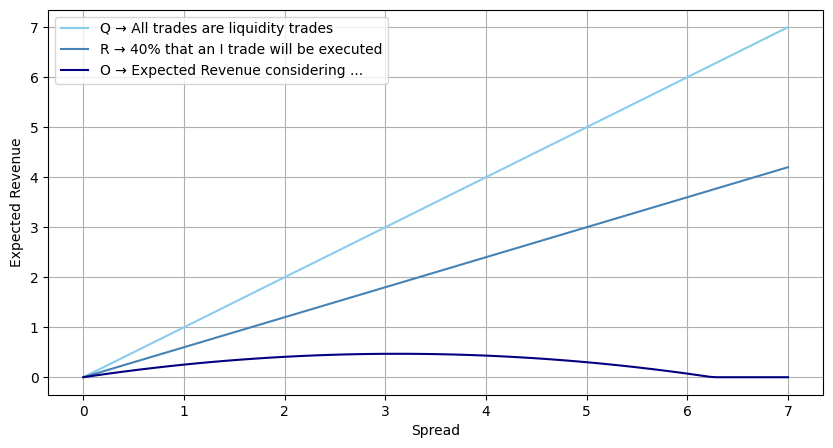

In [15]:
spread = np.linspace(0, 7, 100)
p_I = 0.4
p_Ic = 1 - p_I

# Caso LB = LS


def pi_LB_LS(spread):
    p = 0.5 - 0.08 * spread
    return np.maximum(p, 0)


def pi_Inf(spread):
    return p_Ic * spread


def exp_revenue(spread):
    return pi_LB_LS(spread) * p_Ic * spread


plt.plot(spread, spread, label= 'Q → All trades are liquidity trades')
plt.plot(spread, pi_Inf(spread), label= 'R → 40% that an I trade will be executed')
plt.plot(spread, exp_revenue(spread), label= 'O → Expected Revenue considering ...')
plt.xlabel('Spread')
plt.ylabel('Expected Revenue')
plt.legend()
plt.show()

# Determine he optimal Bid / Ask prices

$$
\max_{K_A, K_B} \Bigg[ (1-p_I)\big( p_{BL}(K_A-S_0) + p_{SL}(S_0 - K_B) \big) 
- p_{I}\Bigg( \int_{K_A}^{\infty} (S-K_A)f(S)\,dS \;+\; \int_{0}^{K_{B}} (K_{B}-S)f(S)\,dS \Bigg) \Bigg] \quad\quad \geq 0
$$

Parametros:
- $S_0 = 19.90$
- $S: [10, 33]$
- $k = 60$
- $\lambda = 3$

In [16]:
S_0 = 19.90
x_0 = np.array([10, 33])
x_0

array([10, 33])

p_1 → Ganancia contra los de liquidez
$$
(1-p_I)\big( p_{BL}(K_A-S_0) + p_{SL}(S_0 - K_B)
$$

p_2 → Pérdida contra los informados que compran al Ask
$$
p_2 = \int_{K_A}^{\infty} (S-K_A)f(S)\,dS
$$

p_3 → Pérdida contra los informados que venden al Bid
$$
p_3 = \int_{0}^{K_{B}} (K_{B}-S)f(S)\,dS

In [17]:
def objective(x, p_i, S_o, K, lambd):
    K_a, K_b = x
    p_1 = (1 - p_i) * (pi_LB_LS(K_a - S_o) * (K_a - S_o) +
                       (pi_LB_LS(S_o - K_b) * (S_o - K_b)))
    p_2 = quad(lambda S: (S - K_a) * PDF_erlang(K, lambd, S), K_a, np.inf)[0]
    p_3 = quad(lambda S: (K_b - S) * PDF_erlang(K, lambd, S), 0, K_b)[0]

    result = -(p_1 - p_i * (p_2 + p_3))
    return result

In [18]:
results = minimize(objective, x_0, args=(p_I, S_0, k, lmbda))

ask_opt = results.x[0].round(4)
bid_opt = results.x[1].round(4)

print(f"Precio Bid Optimo: {bid_opt}" )
print(f"Precio Ask Optimo: {ask_opt}")

Precio Bid Optimo: 16.4517
Precio Ask Optimo: 23.4277


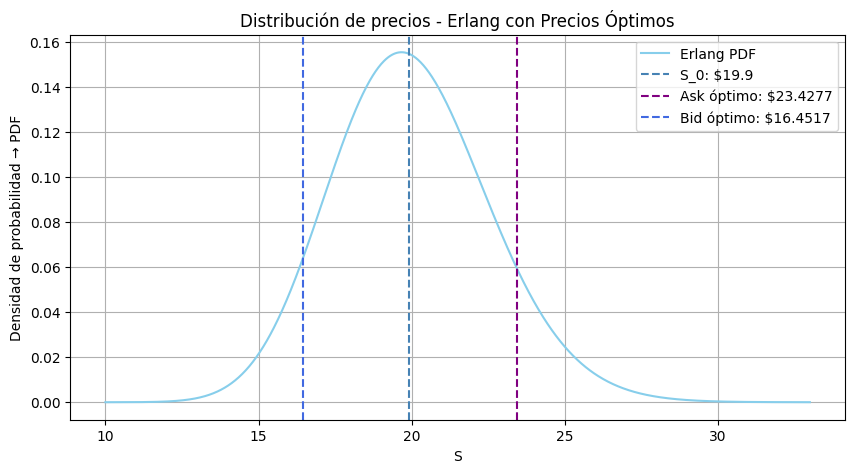

In [19]:
plt.plot(S, erlang, label="Erlang PDF")

plt.axvline(S_0, linestyle='--', color="steelblue", label=f"S_0: ${S_0}")
plt.axvline(results.x[0], linestyle='--', color="purple",
            label=f"Ask óptimo: ${results.x[0].round(4)}")
plt.axvline(results.x[1], linestyle='--', color="royalblue",
            label=f"Bid óptimo: ${results.x[1].round(4)}")

plt.title("Distribución de precios - Erlang con Precios Óptimos")
plt.xlabel('S')
plt.ylabel('Densidad de probabilidad → PDF')
plt.legend()
plt.show()